# Estimate position

References:  
> https://github.com/RaubCamaioni/OpenCV_Position.git  
> https://medium.com/analytics-vidhya/using-homography-for-pose-estimation-in-opencv-a7215f260fdd  
> https://medium.com/analytics-vidhya/tutorial-how-to-scale-and-rotate-contours-in-opencv-using-python-f48be59c35a2  
>
> maybe later with distance: https://www.baeldung.com/cs/sort-points-clockwise  

## Imports, definitions and loadings

In [1]:
import numpy as np
np.set_printoptions(suppress=True)
import matplotlib.pyplot as plt
import cv2
import traceback

In [2]:
K = np.loadtxt('../../cam-config/mtx.txt')
K

array([[655.19135007,   0.        , 319.04529769],
       [  0.        , 655.56447367, 223.19439802],
       [  0.        ,   0.        ,   1.        ]])

In [3]:
COMPARED_SIZE = (24, 68)
AREA_BORDER = COMPARED_SIZE[0] * COMPARED_SIZE[1]
WIDTH_TO_HEIGHT = COMPARED_SIZE[0] / COMPARED_SIZE[1]
SIZE_FACTOR = 0.3
MIN_WIDTH_TO_HEIGHT = WIDTH_TO_HEIGHT * (1 - SIZE_FACTOR)
MAX_WIDTH_TO_HEIGHT = WIDTH_TO_HEIGHT * (1 + SIZE_FACTOR)

In [4]:
def prepare_rotation(min_rect):
    """
    Prepare portrait rotation. No difference between up and down.
    """
    
    width_to_height = min_rect[1][0] / min_rect[1][1]
    
    if width_to_height >= 1:
        return 90 - min_rect[2]
    else:
        return min_rect[2]

In [5]:
def rotate_and_crop(image, min_area_rect, factor=1.3, cnt=None):
    box = cv2.boxPoints(min_area_rect)
    box = np.intp(box)

    width = round(min_area_rect[1][0])
    height = round(min_area_rect[1][1])

    size_of_transformed_image = max(min_area_rect[1])
    min_needed_height = int(np.sqrt(2 * np.power(size_of_transformed_image, 2)))

    width_to_height = min_area_rect[1][0] / min_area_rect[1][1]
    
    if width_to_height >= 1:
        min_rect_angle_deg = -1 * (90 - min_area_rect[2])
    else:
        min_rect_angle_deg = min_area_rect[2]    

    size = (min_needed_height, min_needed_height)

    x_coordinates_of_box = box[:,0]
    y_coordinates_of_box = box[:,1]
    x_min = min(x_coordinates_of_box)
    x_max = max(x_coordinates_of_box)
    y_min = min(y_coordinates_of_box)
    y_max = max(y_coordinates_of_box)

    center = (int((x_min+x_max)/2), int((y_min+y_max)/2))
    cropped = cv2.getRectSubPix(image, size, center) 
    M = cv2.getRotationMatrix2D((size[0]/2, size[1]/2), min_rect_angle_deg, 1.0)
    cropped = cv2.warpAffine(cropped, M, size)

    if width_to_height >= 1:
        cropped_rotated = cv2.getRectSubPix(cropped, (int(factor * height), int(factor * width)), (size[0]/2, size[1]/2))
    else:
        cropped_rotated = cv2.getRectSubPix(cropped, (int(factor * width), int(factor * height)), (size[0]/2, size[1]/2))

    if cnt is not None:
        hull_pts = extract_feature_pts(cnt)
        hull_pts = np.array(merge_points(hull_pts)) - min_area_rect[0]
        rot_pts = np.zeros((len(hull_pts), 2))

        for idx, pt in enumerate(hull_pts):
            angle_rad = np.arctan2(pt[1], pt[0]) - np.deg2rad(min_rect_angle_deg)
            dist = np.hypot(pt[0], pt[1])
            pt_x = dist * np.cos(angle_rad)
            pt_y = dist * np.sin(angle_rad)
            rot_pts[idx] = pt_x, pt_y

    return cropped_rotated, rot_pts

In [6]:
def extract_cnts(img):
    gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    blurred = cv2.blur(gray_img, (3,3))
    
    sigma = 0.33
    v = np.median(blurred)
    
    #---- apply automatic Canny edge detection using the computed median----
    lower = int(max(0, (1.0 - sigma) * v))    #---- lower threshold
    upper = int(min(255, (1.0 + sigma) * v))  #---- upper threshold
    thresh_img = cv2.Canny(blurred, lower, upper)
    cnts, _ = cv2.findContours(thresh_img, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    return cnts, gray_img

In [7]:
def filter_cnts(cnts, gray_img=None, AREA_BORDER=None):
    filtered_list = []
    pos_filtered_to_pos_source = {}
    pos_filtered = 0
    center_list = []
    hull_rot_pts = []
    too_close = False
    for pos_source, con in enumerate(cnts):
        min_rect = cv2.minAreaRect(con)
        center, size, angle_deg = min_rect
        area = size[0] * size[1]

        if AREA_BORDER is not None and area < AREA_BORDER:
            continue
    
        low_value = min(size[0], size[1])
        high_value = max(size[0], size[1])
        if high_value == 0:
            continue
            
        width_to_height = low_value / high_value
    
        if MIN_WIDTH_TO_HEIGHT < width_to_height < MAX_WIDTH_TO_HEIGHT:
            for c_point in center_list:
                too_close = np.all(np.isclose(center, c_point, rtol=0, atol=20))
                if too_close:
                    break
    
            if too_close:
                continue
            center_list.append(center)

            if gray_img is not None:
                cropped_img, rot_pts = rotate_and_crop(gray_img, min_rect, cnt=con)
                db_pt = extract_feature_pts(con)
                hull_rot_pts.append(rot_pts)
                small_img = cv2.resize(cropped_img, COMPARED_SIZE)
                filtered_list.append(small_img)
            pos_filtered_to_pos_source[pos_filtered] = pos_source
            pos_filtered += 1
    
    filtered_list = np.array(filtered_list)   
    return filtered_list, pos_filtered_to_pos_source, hull_rot_pts

In [8]:
def sort_cnts(prediction, pos_filtered_to_pos_source, cnts, filtered_list):
    positive_contours = []
    negative_contours = []
    
    for pos, value in enumerate(prediction):
        idx = pos_filtered_to_pos_source[pos]
        if value[0] >= 0.5:
            positive_contours.append(cnts[idx])
        else:
            negative_contours.append(cnts[idx])

    return positive_contours, negative_contours

In [9]:
def extract_feature_pts(pos_cnt):
    retval = cv2.arcLength(pos_cnt, True)
    points = cv2.approxPolyDP(pos_cnt, 0.04 * retval, True)
    return points

In [10]:
def merge_points(points, MAX_MERGE_DIST = 4):
    to_merge = []
    checked_points_idx = []
    last_to_merge = False
    for idx in range(len(points)-1):
        first_point = points[idx, 0]
        if idx not in checked_points_idx:
            to_merge_bundle = [first_point]
            
            for idx2 in range(idx+1, len(points)):
                second_point = points[idx2, 0]
                dist = np.abs(first_point - second_point)
                
                if dist[0] < MAX_MERGE_DIST and dist[1] < MAX_MERGE_DIST:
                    to_merge_bundle.append(second_point)
                    checked_points_idx.append(idx2)
                    if idx2 == len(points)-1:
                        last_to_merge = True
    
            to_merge.append(to_merge_bundle)
    
    if not last_to_merge:
        to_merge.append([points[-1, 0]])

    filtered_points = []
    for to_merge_bundle in to_merge:
        if len(to_merge_bundle) == 1:
            filtered_points.append(to_merge_bundle[0])
        else:
            filtered_point = np.sum(to_merge_bundle, axis=0)/ len(to_merge_bundle)
            filtered_points.append(filtered_point)

    return filtered_points

In [11]:
def more_pts_up(pts, center=None):
    if center is not None:
        y_max = center[1]
    else:
        y_max = 0
        
    pts_up = 0
    pts_down = 0

    for x, y in pts:
        if y < y_max:
            pts_up += 1
        else:
            pts_down += 1

    return pts_down < pts_up

In [12]:
def angle_x_axis(pt):
    angle_rad = np.arctan2(pt[0], pt[1])
    if angle_rad < 0:
        angle_rad += 2 * np.pi
    return angle_rad

In [13]:
def get_max_dist_reference(pts, ref_up):
    max_dist = 0
    min_idx = -1
    for idx, pt in enumerate(pts):
        dist = np.power(pt[0], 2) + np.power(pt[1], 2)
        if max_dist < dist:
            if ref_up and pt[1] < 0: # up is lower
                min_idx = idx
                max_dist = dist
            elif not ref_up and 0 < pt[1]:
                min_idx = idx
                max_dist = dist
            
    # TODO: abort if min_idx == -1        
    return pts[min_idx]

In [14]:
def rot_centered_pts(pts, ref_angle_rad):
    rot_pts = np.zeros((len(pts), 2))
    for idx, pt in enumerate(pts):
        angle_rad = np.arctan2(pt[1], pt[0]) + ref_angle_rad
        dist = np.hypot(pt[0], pt[1])
        pt_x = dist * np.cos(angle_rad)
        pt_y = dist * np.sin(angle_rad)
        rot_pts[idx] = pt_x, pt_y
        
    return rot_pts

In [15]:
def sort_pts_by_angles(rot_pts, org_pts):
    angles_rad = [angle_x_axis(pt) for pt in rot_pts]
    idx_sorted = np.argsort(angles_rad)
    return org_pts[idx_sorted]

In [16]:
def sort_pt_biggest_dist_center(pts, ref_up, org_pts):
    closest_y = get_max_dist_reference(pts, ref_up)
    ref_angle_rad = (np.pi / 2) - np.arctan2(closest_y[1], closest_y[0])
    rot_pts = rot_centered_pts(pts, ref_angle_rad)
    return sort_pts_by_angles(rot_pts, org_pts)   

In [17]:
def calc_rot_and_trans(H, K):
    H = H.T
    h1 = H[0]
    h2 = H[1]
    h3 = H[2]
    K_inv = np.linalg.inv(K)
    L = 1 / np.linalg.norm(np.dot(K_inv, h1))
    r1 = L * np.dot(K_inv, h1)
    r2 = L * np.dot(K_inv, h2)
    r3 = np.cross(r1, r2)
    
    T = L * np.dot(K_inv, h3)
    print(T)
    
    R = np.array([[r1], [r2], [r3]])
    R = np.reshape(R, (3, 3))
    U, S, V = np.linalg.svd(R, full_matrices=True)
    U = np.matrix(U)
    V = np.matrix(V)
    R = U * V
    
    alpha = np.arctan2(R[2, 1], R[2, 2])
    beta = np.arctan2(-R[2, 0], np.sqrt(R[2, 1] * R[2, 1] + R[2, 2] * R[2, 2]))
    gamma = np.arctan2(R[1, 0], R[0, 0])
    
    text = f'rX: {np.rad2deg(alpha):0.2f} rY: {np.rad2deg(beta):0.2f} rZ: {np.rad2deg(gamma):0.2f}'
    print(text)
    return ((alpha, beta, gamma), T)

In [18]:
def est_pos_in_img(img, model, points_printed):
    if img is None:
        raise IOError('file not valid')
    
    cnts, gray_img = extract_cnts(img)
    filtered_list, pos_filtered_to_pos_source, hull_rot_pts = filter_cnts(cnts, gray_img)

    if not len(filtered_list):
        print('no candidate for prediction found')
        return None, None
    
    prediction = model.predict(filtered_list)
    print(prediction.shape)
    print(prediction)

    pos_cnts, neg_cnts = sort_cnts(prediction, pos_filtered_to_pos_source, cnts, filtered_list)
    
    cv2.drawContours(img, pos_cnts, -1, (0,0,255), 2)
    cv2.drawContours(img, neg_cnts, -1, (255,0,0), 2)
    
    img_points = extract_feature_pts(pos_cnts[0])
    img_points = merge_points(img_points)
    if len(img_points) != 5:
        raise ValueError(f'expected 5 points, but got {len(img_points)} at {img_points}')
    
    img_points = np.reshape(img_points, (5,2))
    idx = np.argwhere(prediction >= 0.5)[0][0]
    rot_points = hull_rot_pts[idx]
    
    ref_up = more_pts_up(rot_points)
    img_points = sort_pt_biggest_dist_center(rot_points, ref_up, img_points)

    for idx, pt in enumerate(img_points):
        tmp_pt = pt.astype(int)
        cv2.circle(img, tmp_pt, 5, (255), -1)
        cv2.putText(img, str(idx), (tmp_pt[0], tmp_pt[1]+10), cv2.FONT_HERSHEY_SIMPLEX, 2, (255))
    plt.imshow(img)
    plt.show()
    
    H, mask = cv2.findHomography(points_printed, img_points, cv2.RANSAC)
    return calc_rot_and_trans(H, K)

In [19]:
points_printed = np.loadtxt('../coords_of_arrow.txt', dtype=int)
print(points_printed)
print('-------------')
points_printed = sort_pt_biggest_dist_center(points_printed, False, points_printed)
print(points_printed)

[[   0  118]
 [  45   61]
 [ -45   61]
 [ -22 -118]
 [  22 -118]]
-------------
[[   0  118]
 [  45   61]
 [  22 -118]
 [ -22 -118]
 [ -45   61]]


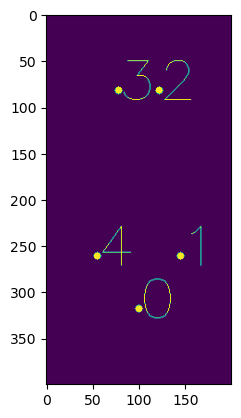

In [20]:
tmp = points_printed + (100, 200)
tmp_img = np.zeros((400, 200))
for idx, pt in enumerate(tmp):
    cv2.circle(tmp_img, pt, 4, (255, 255, 255), -1)
    cv2.putText(tmp_img, str(idx), (pt[0], pt[1]+10), cv2.FONT_HERSHEY_SIMPLEX, 2, (255, 255, 255))
    
plt.imshow(tmp_img)

In [21]:
if not 'model' in dir():
    print('load model...')
    from keras.models import load_model
    model = load_model('arrow_detection.keras')
    print('loaded model')
    
else:
    print('model already loaded')
    
model.trainable = False

load model...


2025-01-31 17:00:57.782077: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


loaded model


## 50 cm test

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step
(1, 1)
[[0.9998032]]


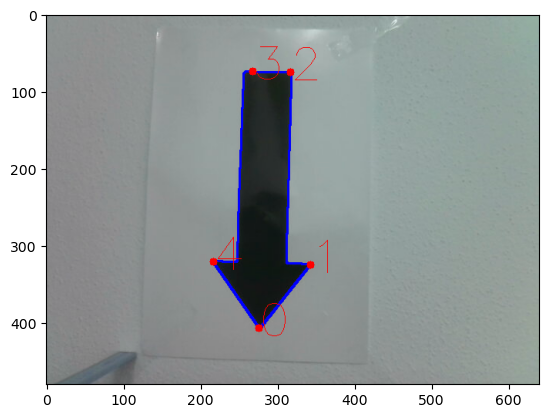

[-22.4234582    9.64024731 462.91156122]
rX: 6.93 rY: 17.33 rZ: -2.71


In [23]:
img_filename = '../example-images/50_cm.jpg'

img = cv2.imread(img_filename)
try:
    _ = est_pos_in_img(img, model, points_printed)
except Exception as e:
    print(traceback.format_exc())

462.91156122 mm ~ 463 mm ~ 46 cm => close to 50 cm

ca. 17 deg rotation?

## 70 cm test

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
(2, 1)
[[0.00179218]
 [0.9996734 ]]


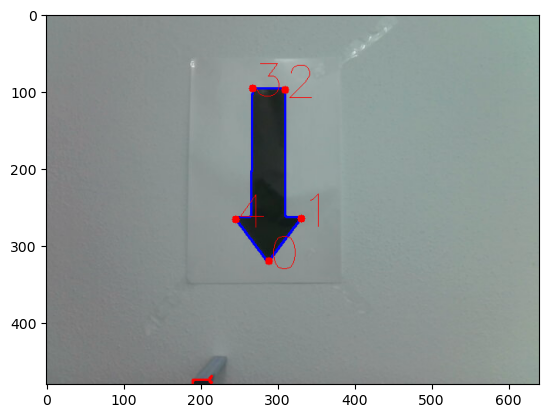

[-31.18782695 -15.95925727 682.66510184]
rX: 1.62 rY: 12.95 rZ: 0.11


In [24]:
img_filename = '../example-images/70_cm.jpg'

img = cv2.imread(img_filename)
try:
    _ = est_pos_in_img(img, model, points_printed)
except Exception as e:
    print(traceback.format_exc())

682.66510184 mm ~ 683 mm == 68.3 cm => close to 70 cm

# Translation test

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
(1, 1)
[[0.99973947]]


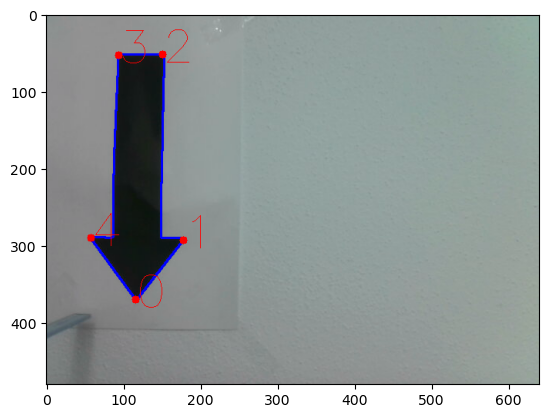

[-145.47334601  -10.54928604  476.8353082 ]
rX: 3.85 rY: -6.09 rZ: -0.56


In [25]:
img_filename = '../example-images/translation.jpg'

img = cv2.imread(img_filename)
try:
    _ = est_pos_in_img(img, model, points_printed)
except Exception as e:
    print(traceback.format_exc())

476.8353082 mm ~47.7cm => close to 50 cm

# Sherring test

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
(1, 1)
[[0.9998462]]


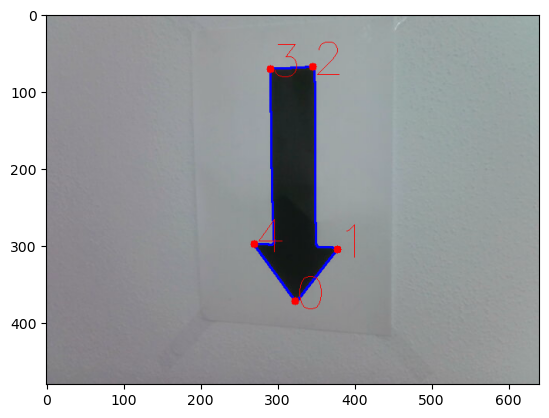

[  1.39433335   0.84854963 509.18158441]
rX: -6.22 rY: -19.40 rZ: 0.92


In [26]:
img_filename = '../example-images/sheering.jpg'

img = cv2.imread(img_filename)
try:
    _ = est_pos_in_img(img, model, points_printed)
except Exception as e:
    print(traceback.format_exc())

509.18158441 ~ 50.9 cm => close to 50 cm; good  
-19.4 deg could be ok (unmeasured)  

# Rotation test

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
(1, 1)
[[0.9997277]]


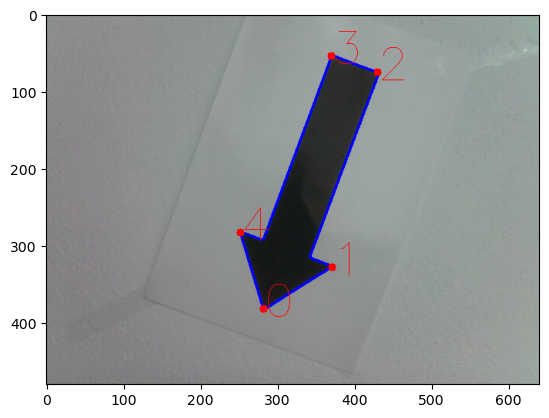

[ 15.52633227   0.17728084 461.18302251]
rX: 1.13 rY: -4.22 rZ: -20.31


In [27]:
img_filename = '../example-images/rotation.jpg'

img = cv2.imread(img_filename)
try:
    _ = est_pos_in_img(img, model, points_printed)
except Exception as e:
    print(traceback.format_exc())

461.18302251 mm ~ 46.1 cm => close to 50 cm

## Stronger rotation test

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
(1, 1)
[[0.9980891]]


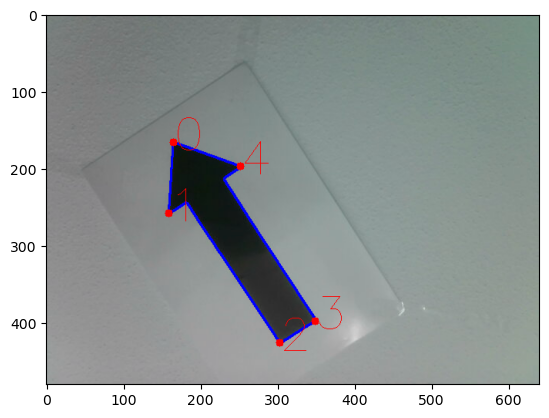

[-57.53517277  54.82132077 524.22702499]
rX: -7.29 rY: -1.64 rZ: -147.31


In [28]:
img_filename = '../example-images/stronger_rotation.jpg'

img = cv2.imread(img_filename)
try:
    _ = est_pos_in_img(img, model, points_printed)
except Exception as e:
    print(traceback.format_exc())

524.22702499 mm ~ 52.4 cm => close to 50 cm